In [2]:
import os
import sys
import time
import configparser
%matplotlib inline
%load_ext autoreload
%autoreload 2

module_dir = os.path.abspath('../src')  # Adjust path as needed
sys.path.append(module_dir)

config = configparser.ConfigParser()
config.read('config_user.ini')

#TO BE CONFIGURED FROM CONFIG FILE
os.environ['ICTDIR'] = config['Paths']['ICTDIR']
os.environ["PATH"] = os.environ["PATH"] + config['Paths']['PATH_APPEND']
# Define the folder base path these are to run in local
base_path = config['Paths']['BASE_PATH']
path_to_wf = config['Paths']['PATH_TO_WF']

print(os.environ["PATH"])

/Users/jjgomezcadenas/Software/geant4-11.2.2-build/bin:/Users/jjgomezcadenas/miniconda3/envs/IC-3.8-2024-06-08/bin:/Users/jjgomezcadenas/miniconda3/condabin:/Users/jjgomezcadenas/.juliaup/bin:/Users/jjgomezcadenas/.nix-profile/bin:/nix/var/nix/profiles/default/bin:/usr/local/bin:/System/Cryptexes/App/usr/bin:/usr/bin:/bin:/usr/sbin:/sbin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/local/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/bin:/var/run/com.apple.security.cryptexd/codex.system/bootstrap/usr/appleinternal/bin:/opt/X11/bin:/Library/Apple/usr/bin:/Library/TeX/texbin:/Users/jjgomezcadenas/.local/bin:/opt/homebrew/bin:/opt/homebrew/sbin:/Users/jjgomezcadenas/.local/bin:/Users/jjgomezcadenas/NEXT/IC/bin


In [3]:
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.gridspec as gridspec
import numpy as np
from scipy.signal import find_peaks, peak_widths, peak_prominences

In [4]:
from peak_functions import find_peak_params, rebin_sum, s12_energy, print_peak_pars

In [5]:
from aux_functions import check_folder_exists, get_filename_event, read_waveforms
from aux_functions import make_temp_file, launch_reco_irene, read_irene
from ic_functions import deconvolve, suppress_glow, find_dead_pmts, corrected_sum_without_dead_pmts 
from ic_functions import active_pmts, sgn_sipms
from plot_functions import plot_sum_waveform, plot_waveform  
from plot_functions import plot_waveform_zoom_peak, plot_waveform_zoom_peaks 
from plot_functions import plot_waveform_right_peak, plot_waveform_right_peaks
from plot_functions import plot_waveform_pmts, plot_pmt_max_rms, histo_q_sigma,  histo_q
from plot_functions import plot_sipm_max_rms
from plot_functions import plot_sum_PMT, plot_single_PMT, plot_sipm
from plot_functions import plot_peaks 
import irene_params as ip
from irene_params import get_units, get_s1_tmin_tmax, get_maw, get_thr_sipmw, get_s2_tmin_tmax, get_var_with_units

In [6]:
from invisible_cities.cities.components import deconv_pmt, get_number_of_active_pmts
from invisible_cities.cities.components import calibrate_pmts, zero_suppress_wfs, calibrate_sipms 
from invisible_cities.cities.components import compute_and_write_pmaps,collect,wf_from_files
from invisible_cities.database.load_db import DataSiPM
from invisible_cities.database.load_db import DataPMT

In [7]:
from invisible_cities.database import load_db 

In [8]:
from invisible_cities.core   import tbl_functions        as tbl

In [9]:
from invisible_cities.dataflow import  dataflow as  fl
from invisible_cities.dataflow.dataflow import pipe, push, sink, fork, count

In [10]:
from invisible_cities.reco import peak_functions as pkf

In [11]:
from invisible_cities.types.ic_types  import  minmax
from invisible_cities.types.symbols   import WfType
from invisible_cities.core.system_of_units import adc, pes, mus, ns

# IRENE

In [12]:
print(ip.irene_pars)

{'detector_db': 'next100', 'compression': 'ZLIB4', 'n_baseline': 90000, 'n_baseline_units': 'nounits', 'n_maw': 100, 'n_maw_units': 'nounits', 'thr_maw': 10, 'thr_maw_unit': 'adc', 'thr_csum_s1': 0.1, 'thr_csum_s1_unit': 'pes', 'thr_csum_s2': 0.5, 'thr_csum_s2_unit': 'pes', 'thr_sipm': 1.0, 'thr_sipm_unit': 'pes', 'thr_sipm_typ': 'common', 'pmt_samp_wid': 25, 'pmt_samp_wid_unit': 'ns', 'sipm_samp_wid': 1, 'sipm_samp_wid_unit': 'mus', 's1_lmax': 99, 's1_lmax_unit': 'nounit', 's1_lmin': 4, 's1_lmin_unit': 'nounit', 's1_tmax': 1450, 's1_tmax_unit': 'mus', 's1_tmin': 0, 's1_tmin_unit': 'mus', 's1_stride': 4, 's1_stride_unit': 'nounit', 's1_rebin_stride': 1, 's1_rebin_stride_unit': 'nounit', 's2_lmax': 10000, 's2_lmax_unit': 'nounit', 's2_lmin': 400, 's2_lmin_unit': 'nounit', 's2_tmax': 2000, 's2_tmax_unit': 'mus', 's2_tmin': 1450, 's2_tmin_unit': 'mus', 's2_stride': 10, 's2_stride_unit': 'nounit', 's2_rebin_stride': 40, 's2_rebin_stride_unit': 'nounit', 'thr_sipm_s2': 5.0, 'thr_sipm_s2_uni

In [13]:
s1tmx, s1tmn, is1tmx, is1tmn = get_s1_tmin_tmax(ip.irene_pars, tbin_pmt_ns = 25)
print(f"s1tmx = {s1tmx/mus} mus, s1tmn = {s1tmn/mus} mus")
print(f"is1tmx = {is1tmx} mus, s1tmn = {is1tmn} mus")

s1tmx = 1450.0 mus, s1tmn = 0.0 mus
is1tmx = 58000 mus, s1tmn = 0 mus


In [14]:
s2tmx, s2tmn, is2tmx, is2tmn = get_s2_tmin_tmax(ip.irene_pars, tbin_pmt_ns = 25)
print(f"s2tmx = {s2tmx/mus} mus, s2tmn = {s2tmn/mus} mus")
print(f"is2tmx = {is2tmx}, is2tmn = {is2tmn}")

s2tmx = 2000.0 mus, s2tmn = 1450.0 mus
is2tmx = 80000, is2tmn = 58000


In [15]:
tpmt = get_var_with_units("pmt_samp_wid", ip.irene_pars)
tspmt = tpmt/mus
print(f"time pmt = {tpmt} ns")
print(f"time sample pmt  = {tspmt} mus")

time pmt = 25.0 ns
time sample pmt  = 0.025 mus


## Input

#### run number

In [276]:
run_number = 14676

### adc to pes conversion

In [277]:
DataPMTX    = load_db.DataPMT("next100", run_number = 14637)
adc_to_pes = np.abs(DataPMTX.adc_to_pes.values)
adc_to_pes = adc_to_pes[adc_to_pes > 0]
adc_to_pes[(adc_to_pes > 1e+3)] = 0

In [278]:
plot_adc_to_pes = False
if plot_adc_to_pes:
    fig, axs = plt.subplots(1, 1, figsize=(14, 6),dpi=160)
    axs.hist(adc_to_pes, bins=20, color='blue', edgecolor='black', alpha=0.7)
    axs.set_xlabel('ADC to PES')
    axs.set_ylabel('Frequency')
    axs.set_title('ADC to PES for NEXT-100')
    plt.show()

In [279]:
npmts = get_number_of_active_pmts("next100", run_number)
print(f"The data base says we have {npmts} active but 12 of them are disconnected")

The data base says we have 60 active but 12 of them are disconnected


#### PMT and SiPMs positions from DB

In [280]:
PMTPos = DataPMT('next100', 0).filter('XY')
SiPMpos = DataSiPM('next100', 0).filter('XY')
X, Y = PMTPos["X"], PMTPos["Y"]
XSi, YSi = SiPMpos["X"], SiPMpos["Y"]

#### Find data folder and file

In [281]:
folder_path, filelist, nevents_per_file = check_folder_exists(run_number, base_path, path_to_wf)
print(f"Folder path = {folder_path}, filelist = {filelist} events per file = {nevents_per_file}")


Folder path = /Users/jjgomezcadenas/NEXT/analysis//14676//hdf5/data/, filelist = ['run_14676_1809_ldc1_trg0.waveforms.h5'] events per file = 82


#### Event number

In [282]:
event_number = 0

In [283]:
filename, local_ev_number = get_filename_event(filelist, folder_path, nevents_per_file, event_number)
print(f"filename = {filename}, local event number = {local_ev_number}")

filename = /Users/jjgomezcadenas/NEXT/analysis//14676//hdf5/data/run_14676_1809_ldc1_trg0.waveforms.h5, local event number = 0


## Read waveforms

In [284]:
pmtrwf, sipmrwf, n_baseline, sp = read_waveforms(filename, local_ev_number, xbaseline=0.9)
print(f" sensorPars = {sp}, n_baseline = {n_baseline}")

 sensorPars = SensorPars(pmt_time_bins=80000, num_pmts=60, sipm_time_bins=2000, num_sipms=3584), n_baseline = 72000


### Raw WaveForm to Corrected WaveForm   

#### Parameters: n_maw, thr_maw (adcs)

In [285]:
n_maw, thr_maw = get_maw(ip.irene_pars)
print(f"n_maw = {n_maw}, thr_max = {thr_maw} adc")

deconv = deconv_pmt("next100", int(run_number), n_baseline)
cwf    = deconv(pmtrwf)

calibpmts = calibrate_pmts("next100", int(run_number), n_maw, thr_maw)
ccwfs, ccwfs_maw, cwf_sum, cwf_sum_maw   = calibpmts(cwf)

n_maw = 100, thr_max = 10.0 adc


## SiPMs

#### Parameters: sipm_thr (pes)

In [286]:
thr_sipm = get_var_with_units("thr_sipm", ip.irene_pars) 
print(f"thr_sipm = {thr_sipm} pes")   

sipm_rwf_to_cal  = calibrate_sipms("next100", run_number, thr_sipm)
sipmcwf = sipm_rwf_to_cal(sipmrwf)
sipm_sum = np.sum(sipmcwf, axis=0)

thr_sipm = 1.0 pes


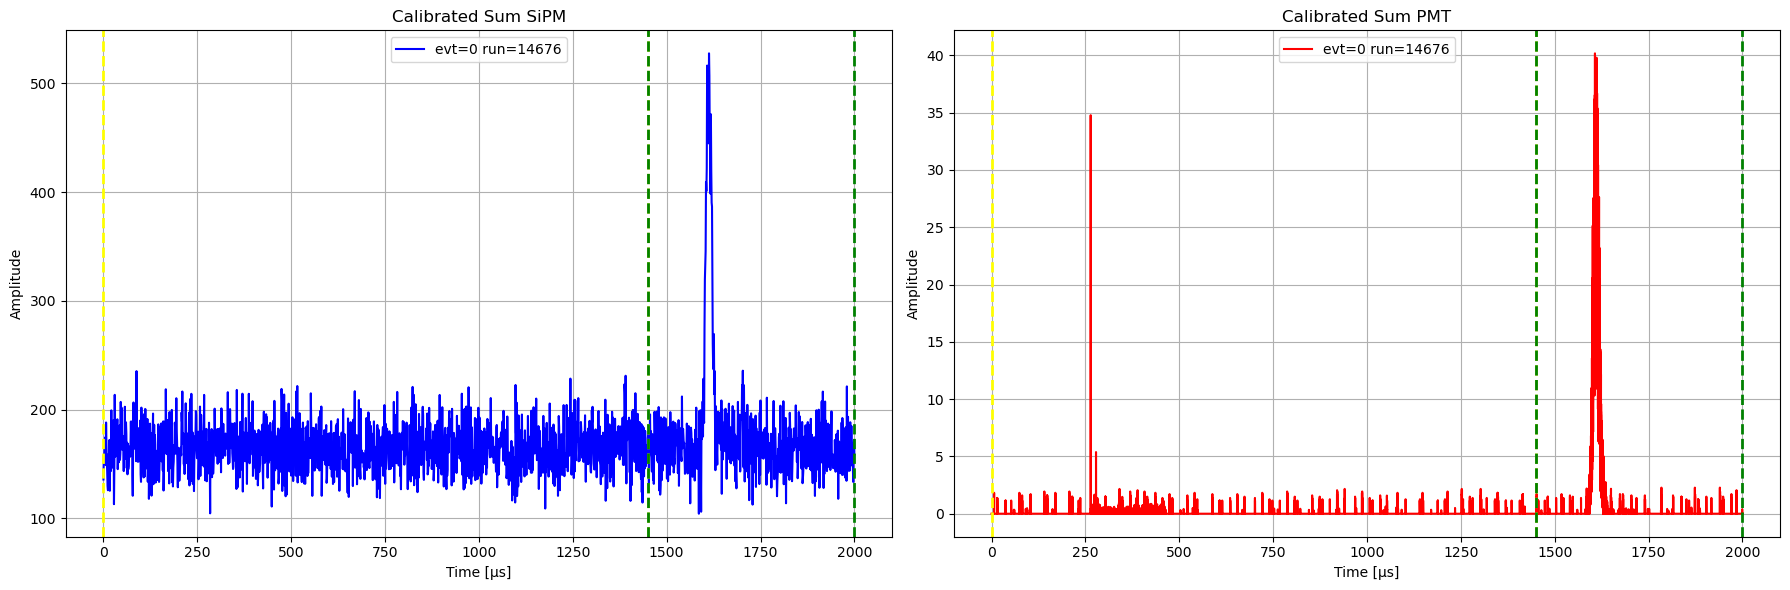

In [287]:
plot_sum_waveform(sipm_sum , cwf_sum_maw, sp.sipm_time_bins, sp.pmt_time_bins, run_number, event_number,
                  s1tmx = s1tmx/mus, s1tmn = s1tmn/mus,s2tmx = s2tmx/mus, s2tmn = s2tmn/mus,
                      figsize=(18, 6), tbin=25e-3)

## Find if there is "glow". If there is one glow spike per window, then suppress it

In [288]:
pp = find_peak_params(cwf_sum_maw, prominence=1000, distance=20)

In [289]:
print_peak_pars(pp, tspmt)

found peaks -->[], time position (mus): []
prominences = []
widths (mus) = []
left ips (mus) = []
right ips (mus) = []
left cuts = [], right cuts = []


In [290]:
if len(pp.proms) > 0:
    plot_waveform(cwf_sum_maw, sp.pmt_time_bins, run_number, event_number, 
                  pp.peaks, pp.widths, pp.left_ips, pp.right_ips,
                  tbin=tspmt)

In [291]:
if len(pp.proms) > 0:
    plot_waveform_zoom_peaks(cwf_sum_maw, run_number, event_number, 
                         pp.peaks, pp.lcuts, pp.rcuts, twindows =(50, 50), 
                         tscale=True, figsize=(18, 6))

In [292]:
if len(pp.proms) > 0:
    sum_cwf_corr = suppress_glow(cwf_sum_maw, pp.peaks, pp.lcuts, pp.rcuts)
else:
    sum_cwf_corr = cwf_sum_maw

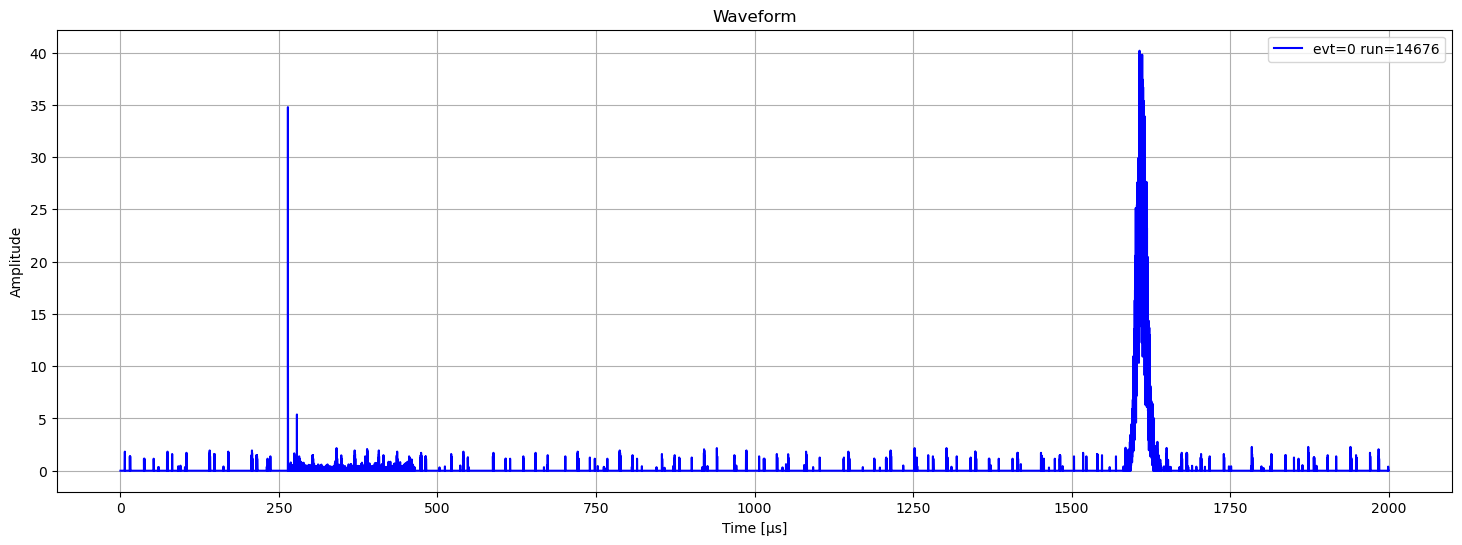

In [293]:
plot_waveform(sum_cwf_corr, sp.pmt_time_bins, run_number, event_number, figsize=(18, 6))

## S2 search

In [294]:
s2_rebin = int(ip.irene_pars["s2_rebin_stride"])
s2_rebin = 80
cwf_s2 = rebin_sum(sum_cwf_corr[is2tmn:is2tmx], s2_rebin)
t2_rebin = cwf_s2.shape[0]
tbins2=tspmt * s2_rebin
print(f"rebined s2 bins (mus) = {tbins2}")

rebined s2 bins (mus) = 2.0


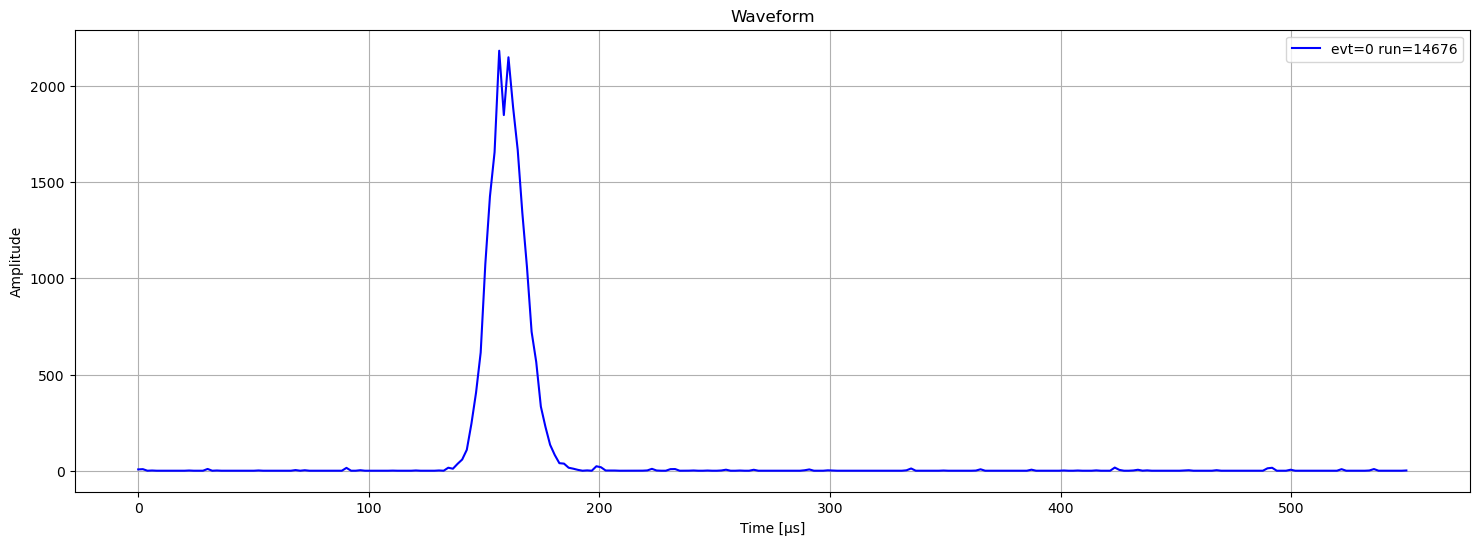

In [295]:
plot_waveform(cwf_s2, t2_rebin, run_number, event_number, figsize=(18, 6), tbin=tbins2)

In [296]:
ps2 = find_peak_params(cwf_s2, prominence=100, distance=10)

In [297]:
print_peak_pars(ps2, tspmt)

found peaks -->[78], time position (mus): [1.95]
prominences = [2183.12035572]
widths (mus) = [0.22076304]
left ips (mus) = [1.87629016]
right ips (mus) = [2.09705319]
left cuts = [57], right cuts = [101]


left cut = 132.44216929615547, right cut = 203.08634188585265


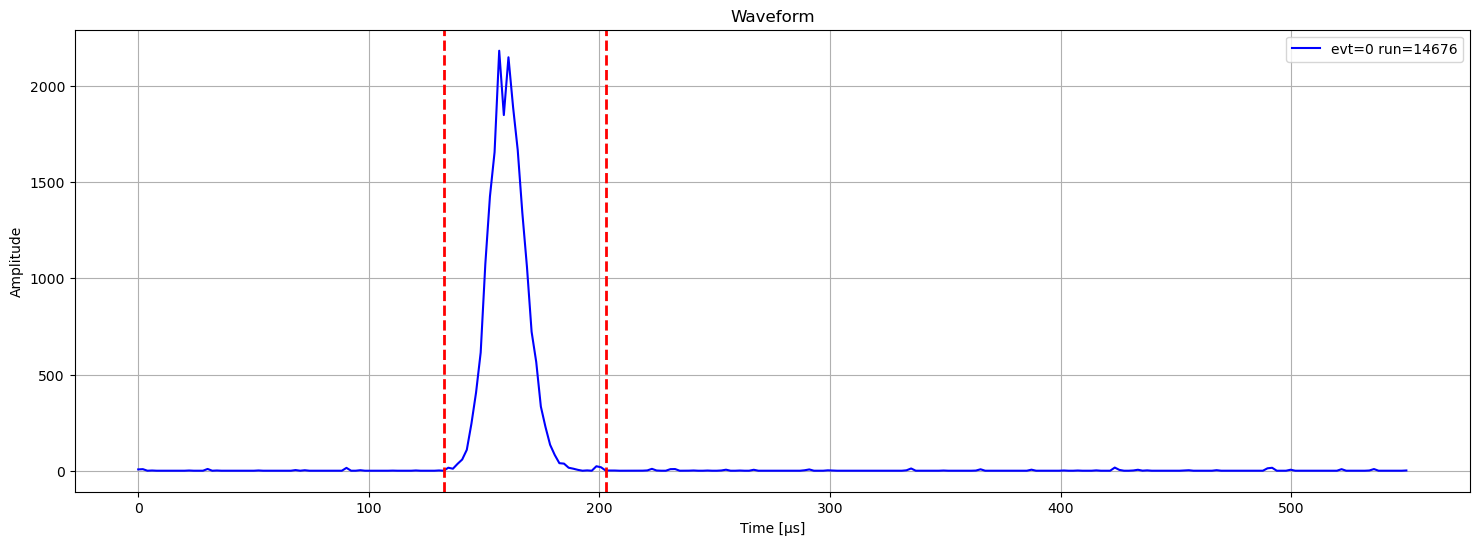

In [298]:
plot_waveform(cwf_s2, t2_rebin, run_number, event_number, 
              ps2.peaks, ps2.widths, ps2.left_ips, ps2.right_ips, tbin=tbins2, 
              figsize=(18, 6))

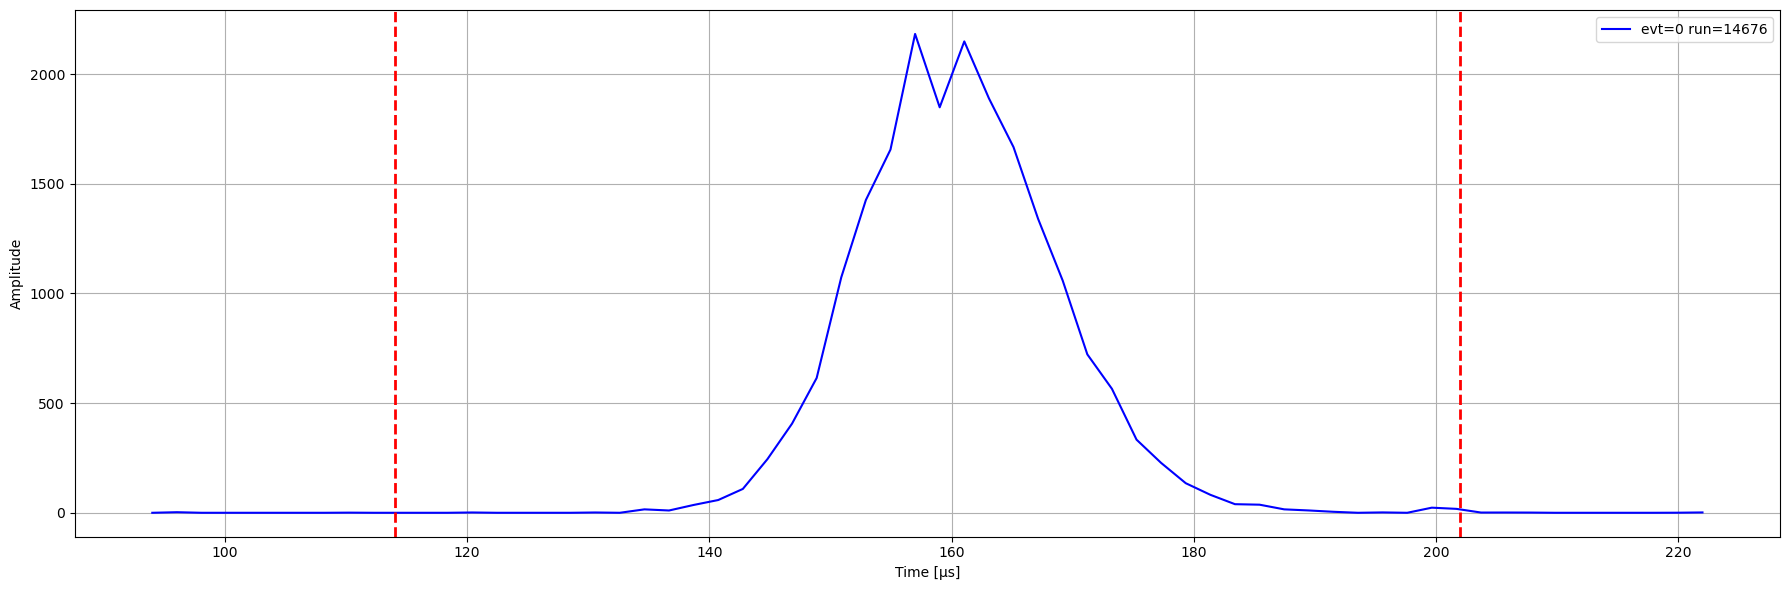

In [299]:
plot_waveform_zoom_peaks(cwf_s2, run_number, event_number, 
                         ps2.peaks, ps2.lcuts, ps2.rcuts,twindows =(10, 10), 
                         tscale=True, tbin=tbins2, figsize=(18, 6))

In [300]:
print(f"Energy of S2 = {s12_energy(cwf_s2, ps2)} pes")

Energy of S2 = [20002.63235441541] pes


## S1 search

In [301]:
s1_rebin = int(ip.irene_pars["s1_rebin_stride"])
cwf_s1 = rebin_sum(sum_cwf_corr[is1tmn:is1tmx], s1_rebin)
t1_rebin = cwf_s1.shape[0]
tbinS1= tspmt * s1_rebin
print(f"s1 rebin = {s1_rebin}, t1 rebin = {t1_rebin}, tbin S1 = {tbinS1}")

s1 rebin = 1, t1 rebin = 58000, tbin S1 = 0.025


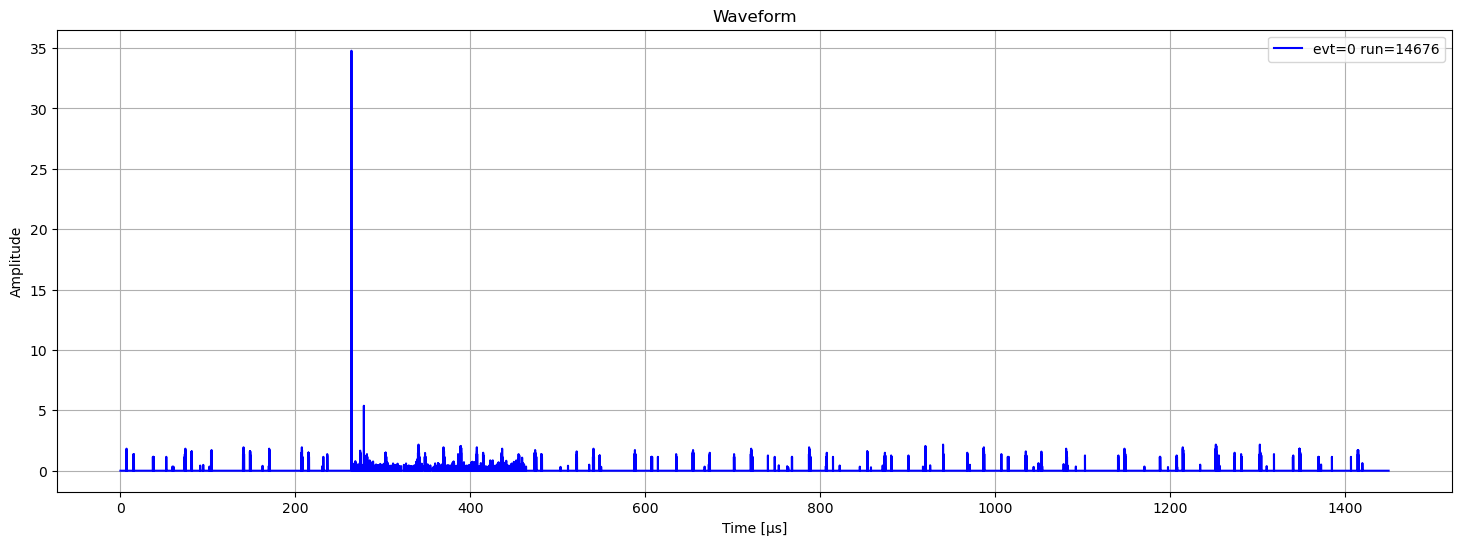

In [302]:
plot_waveform(cwf_s1, t1_rebin, run_number, event_number, figsize=(18, 6), tbin=tbinS1)

In [303]:
ps1 = find_peak_params(cwf_s1, prominence=10, distance=10)

In [304]:
print_peak_pars(ps1, tspmt)

found peaks -->[10565], time position (mus): [264.125]
prominences = [34.77852285]
widths (mus) = [0.10721567]
left ips (mus) = [264.06990544]
right ips (mus) = [264.17712111]
left cuts = [10554], right cuts = [10575]


left cut = 263.9626897719408, right cut = 264.3915524475945


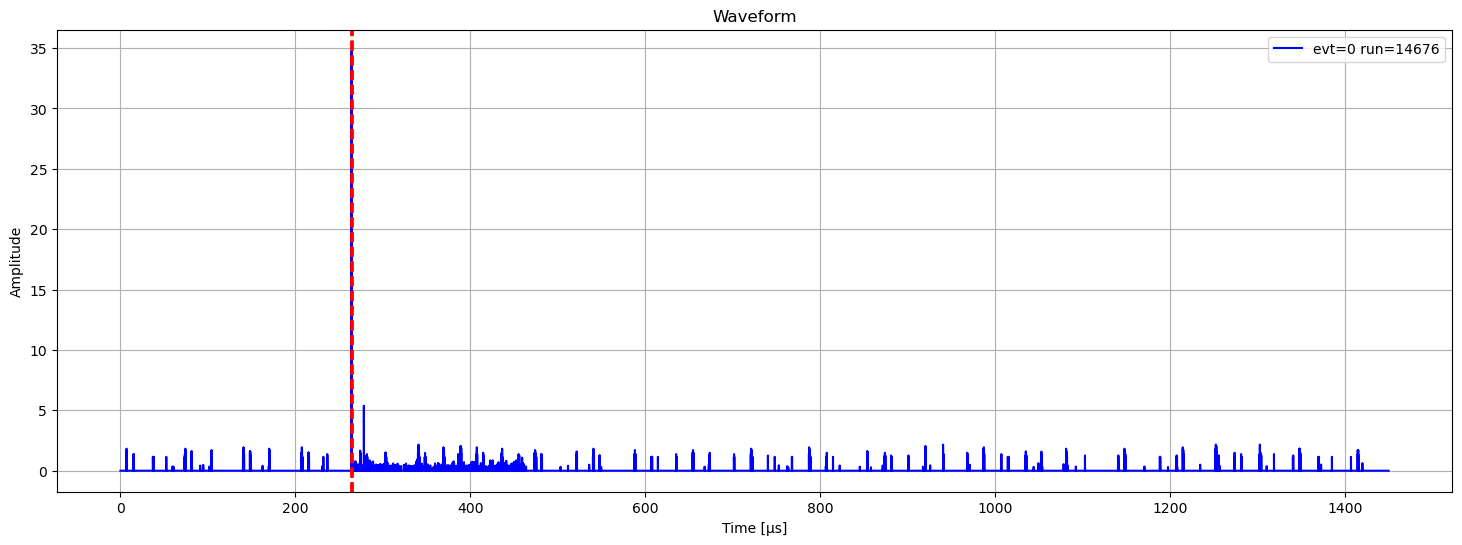

In [305]:
if len(ps1.proms) > 0:
    plot_waveform(cwf_s1, t1_rebin, run_number, event_number, 
              ps1.peaks, ps1.widths, ps1.left_ips, ps1.right_ips,  
              tbin=tbinS1, figsize=(18, 6))

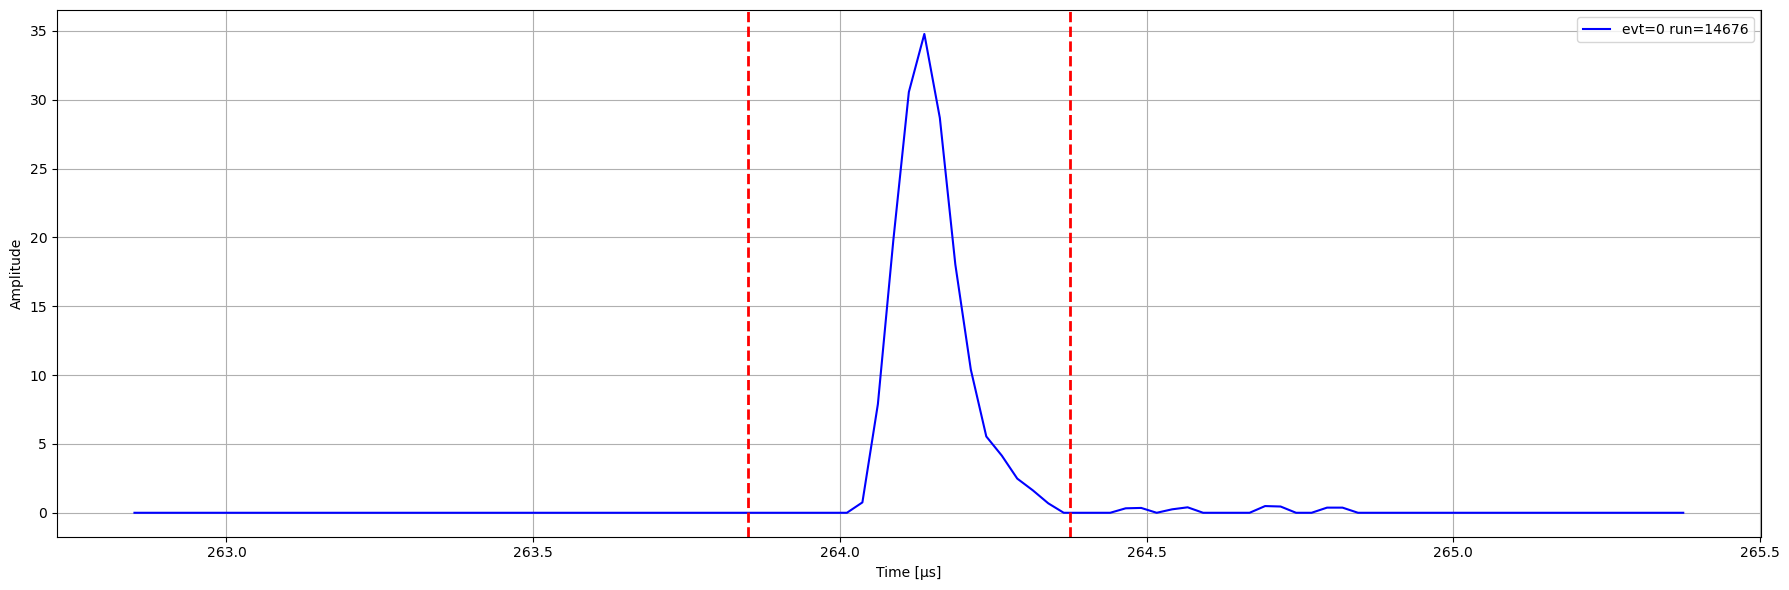

In [306]:
if len(ps1.proms) > 0:
    plot_waveform_zoom_peaks(cwf_s1, run_number, event_number, 
                         ps1.peaks, ps1.lcuts, ps1.rcuts,twindows =(40, 40), 
                         tscale=True, tbin=tbinS1, figsize=(18, 6))

In [307]:
if len(ps1.proms) > 0:
    print(f"Energy of S1 = {s12_energy(cwf_s1, ps1)} pes")
else:
    print(f"S1 not found")

Energy of S1 = [165.42605506398323] pes


## SiPMs

### Search for glow

In [308]:
tsipm = 1.0 # in mus
pg2 = find_peak_params(sipm_sum, prominence=1000, distance=20)
print_peak_pars(pg2, tsipm)

found peaks -->[], time position (mus): []
prominences = []
widths (mus) = []
left ips (mus) = []
right ips (mus) = []
left cuts = [], right cuts = []


In [309]:
if len(pg2.proms) > 0:
    plot_waveform(sipm_sum, sp.sipm_time_bins, run_number, event_number, 
              pg2.peaks, pg2.widths, pg2.left_ips, pg2.right_ips,
              tbin=tsipm)


In [310]:
if len(pg2.proms) > 0:
    plot_waveform_zoom_peaks(sipm_sum, run_number, event_number, 
                         pg2.peaks, pg2.lcuts, pg2.rcuts, twindows =(10, 10), 
                         tscale=True, figsize=(18, 6))

#### Supress glow

In [311]:
if len(pg2.proms) > 0:
    sipm_sum_corr = suppress_glow(sipm_sum, pg2.peaks, pg2.lcuts, pg2.rcuts)
else:
    sipm_sum_corr = sipm_sum

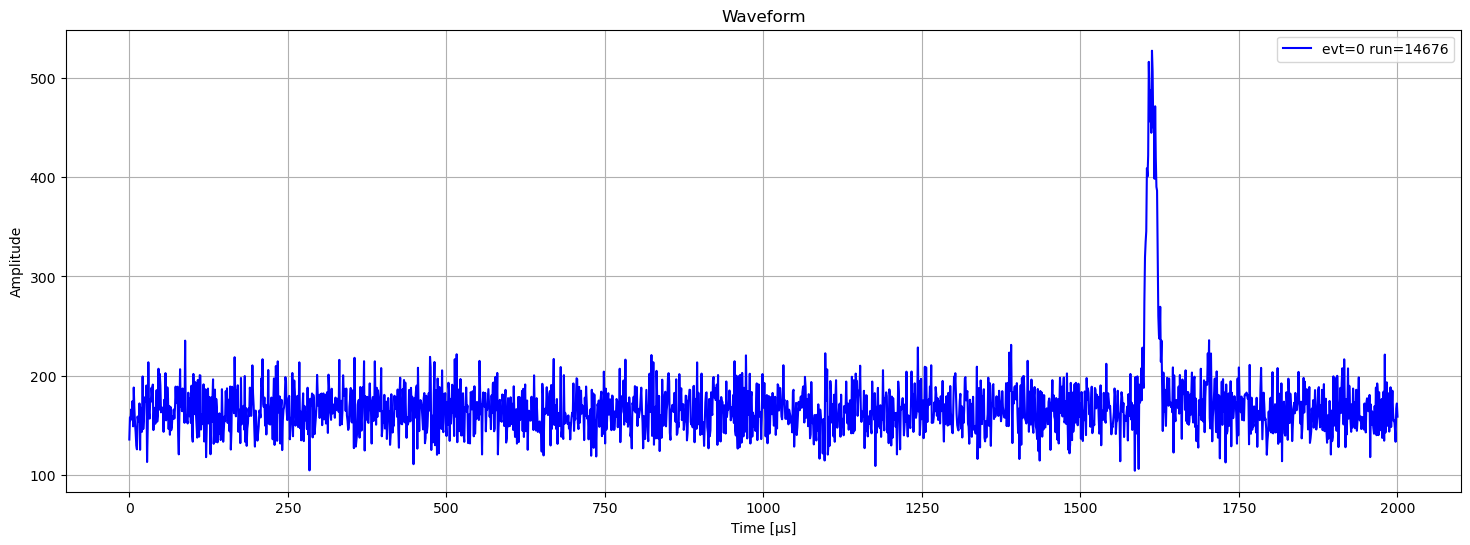

In [312]:
plot_waveform(sipm_sum_corr, sp.sipm_time_bins, run_number, event_number, tbin=tsipm, figsize=(18, 6)) 

#### Rebin

In [313]:
si_rebin = 5
cwf_si = rebin_sum(sipm_sum_corr, si_rebin)
tsi_rebin = cwf_si.shape[0]
tbinsi= tsipm * si_rebin
print(f"si rebin = {si_rebin}, tsi_rebin = {tsi_rebin}, tbin_si = {tbinsi}")

si rebin = 5, tsi_rebin = 400, tbin_si = 5.0


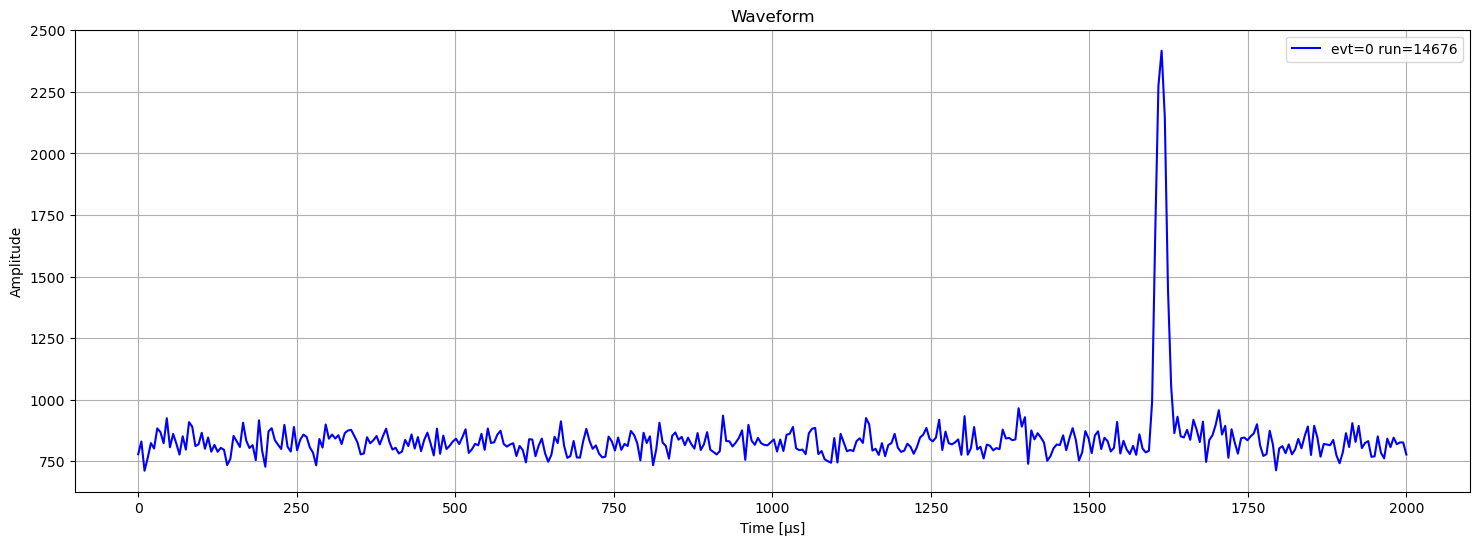

In [314]:
plot_waveform(cwf_si, tsi_rebin, run_number, event_number,   
              tbin=tbinsi, figsize=(18, 6))

#### Zero Suppression

In [315]:
thmean = np.mean(cwf_si[0:300])
thstd = np.std(cwf_si[0:300])
zsthr = thmean + 2 * thstd
print(f"Corrected sipm wvf: mean = {thmean}, std = {thstd}, threshold = {zsthr}")

Corrected sipm wvf: mean = 824.2203247809989, std = 42.070929170652505, threshold = 908.3621831223039


In [316]:
simp_zs = np.where(cwf_si < zsthr, 0, cwf_si)

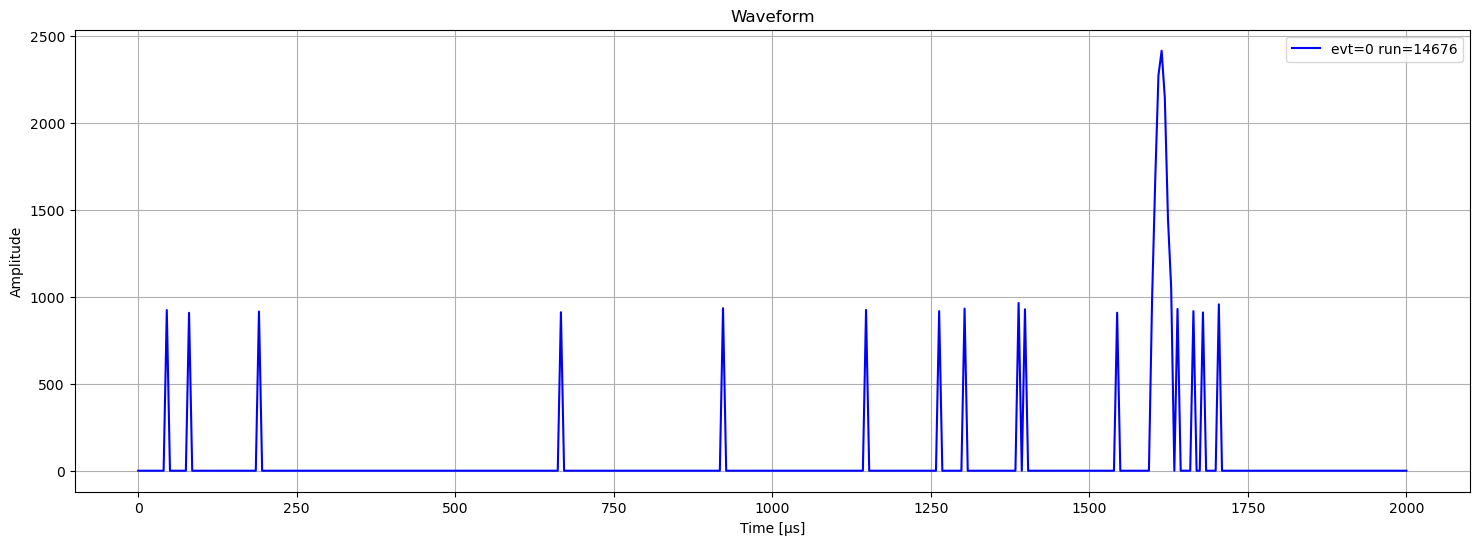

In [317]:
plot_waveform(simp_zs, tsi_rebin, run_number, event_number,   
              tbin=tbinsi, figsize=(18, 6))

#### Find ZS peak

In [318]:
psi = find_peak_params(simp_zs, prominence=100, distance=10)
print_peak_pars(psi, si_rebin)

found peaks -->[  9  38 133 184 229 260 277 308 322 340], time position (mus): [  45  190  665  920 1145 1300 1385 1540 1610 1700]
prominences = [ 924.70448595  916.25466736  912.16495563  935.27734904  925.41914631
  933.12896147  965.26708457  909.53542365 2417.15418315  957.45410022]
widths (mus) = [ 5.          5.          5.          5.          5.          5.
  5.          5.         26.46122858  5.        ]
left ips (mus) = [  42.5         187.5         662.5         917.5        1142.5
 1297.5        1382.5        1537.5        1596.57194258 1697.5       ]
right ips (mus) = [  47.5         192.5         667.5         922.5        1147.5
 1302.5        1387.5        1542.5        1623.03317116 1702.5       ]
left cuts = [6, 35, 130, 181, 226, 257, 274, 305, 308, 337], right cuts = [11, 40, 135, 186, 231, 262, 279, 310, 335, 342]


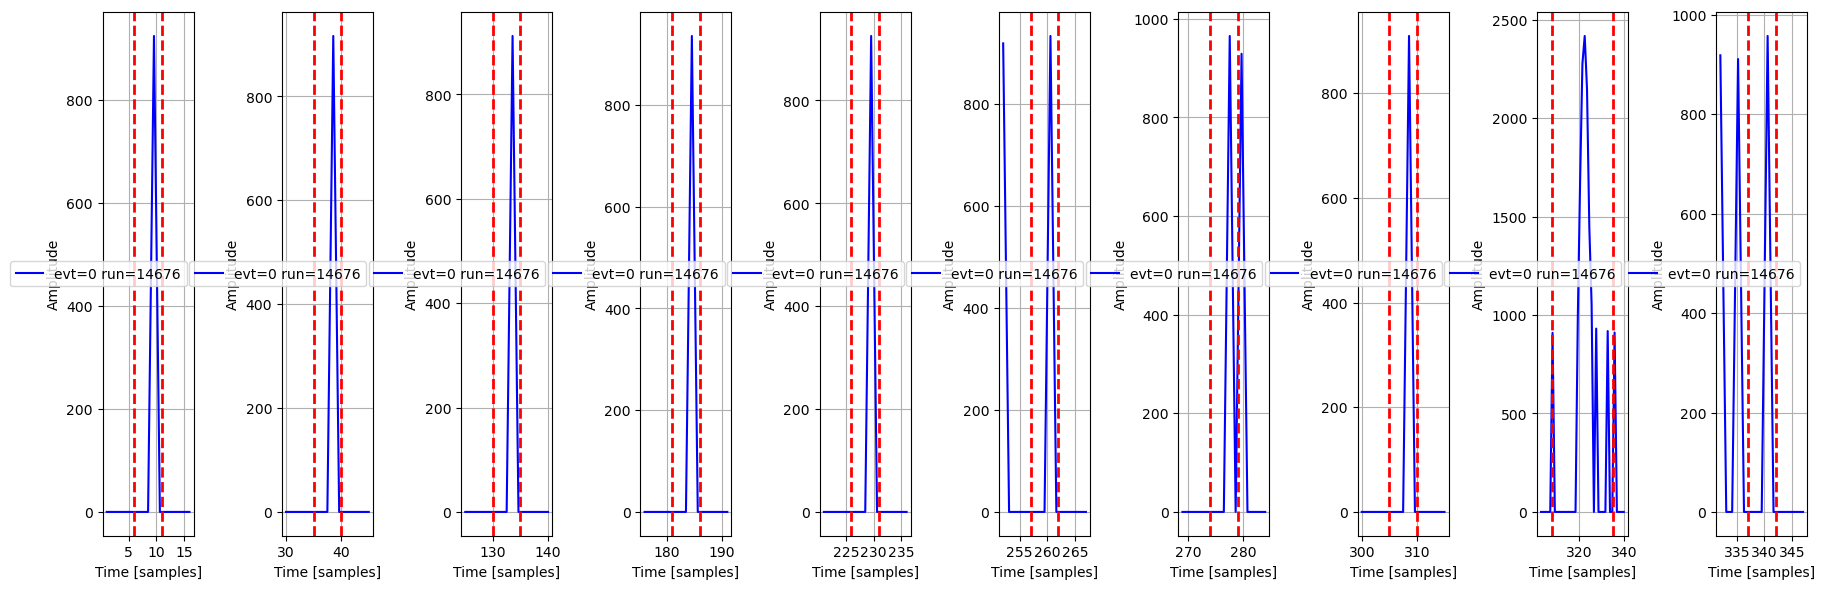

In [319]:
tw = 5*np.ones(len(psi.peaks), dtype=int)
plot_waveform_zoom_peaks(simp_zs, run_number, event_number, 
                         psi.peaks, psi.lcuts, psi.rcuts, twindows =tw, 
                         tbin=si_rebin, tscale=False, figsize=(18, 6))

#### Sum of waveform in peak time window

In [320]:
if len(psi.proms) == 1:
    x0si = psi.lcuts[0]
    x1si = psi.rcuts[0]
else:
    idmx = np.argmax(psi.proms)
    x0si = psi.lcuts[idmx]
    x1si = psi.rcuts[idmx]
print(f"indices sipm: x0 = {x0si}, x1 = {x1si}")

indices sipm: x0 = 308, x1 = 335


In [321]:
sipmsum = np.sum(sipmcwf[:, x0si:x1si], axis=1)

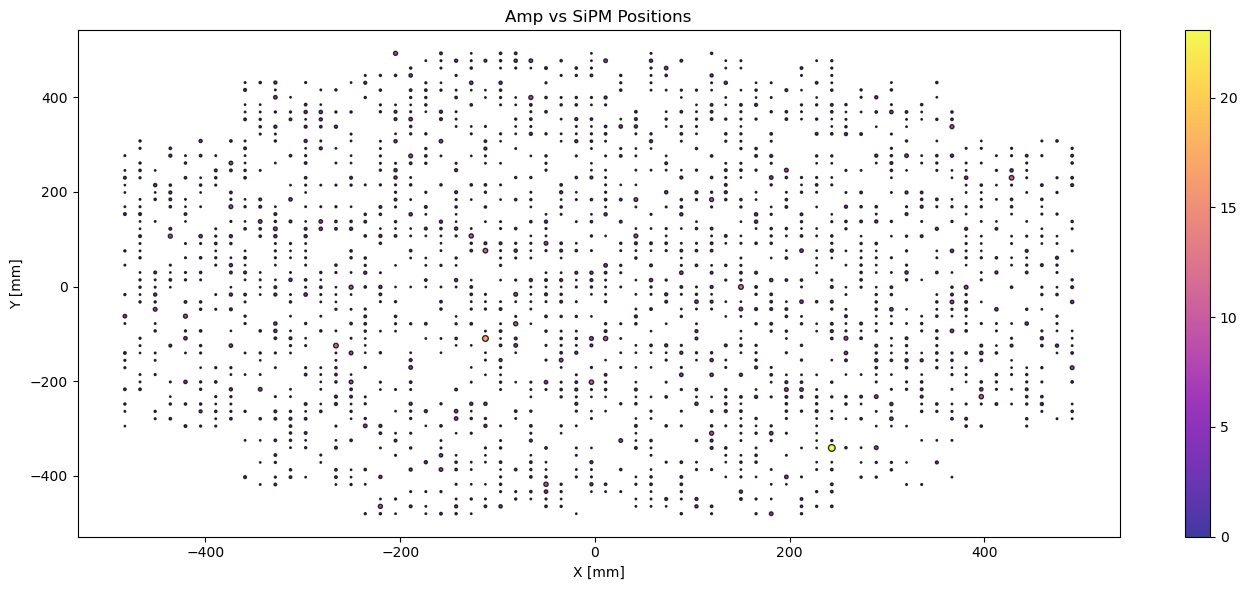

In [322]:
esi = plot_sipm(XSi,YSi,sipmsum, scale=1)

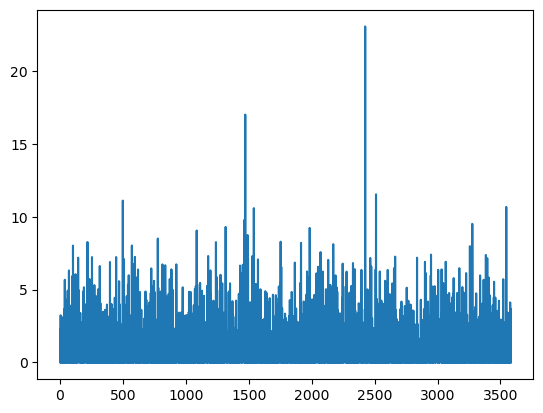

In [323]:
plt.plot(esi)

In [326]:
pxsi = find_peak_params(esi, prominence=20, distance=10)
print_peak_pars(pxsi, 1)

found peaks -->[2425], time position (mus): [2425]
prominences = [23.05887966]
widths (mus) = [1.05334377]
left ips (mus) = [2424.5]
right ips (mus) = [2425.55334377]
left cuts = [2422], right cuts = [2427]


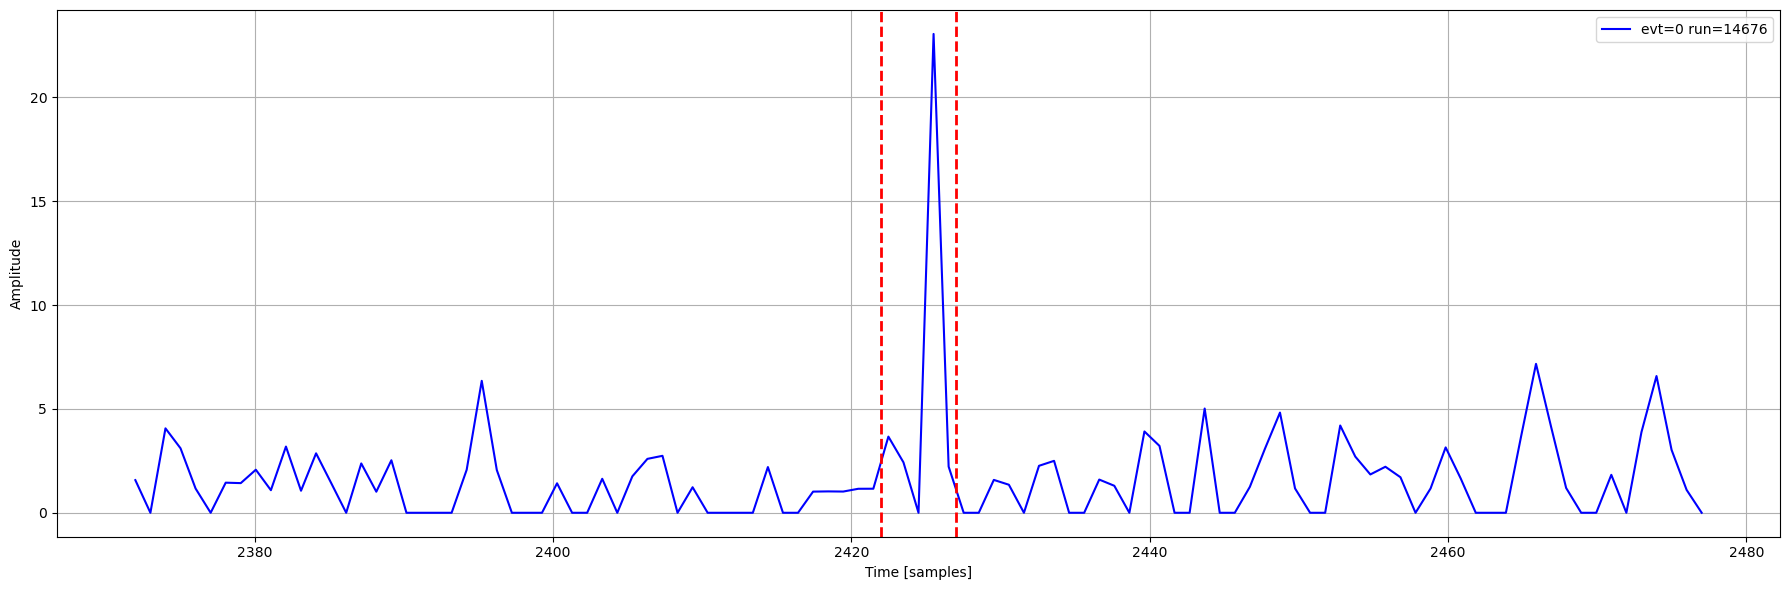

In [327]:
if len(pxsi.proms) > 0:
    plot_waveform_zoom_peaks(esi, run_number, event_number, 
                         pxsi.peaks, pxsi.lcuts, pxsi.rcuts, twindows =(50, 50), 
                         tbin=1, tscale=False, figsize=(18, 6))

In [328]:
if len(pxsi.proms) > 0:
    il = pxsi.lcuts[0]
    ir = pxsi.rcuts[0]
    xSi = XSi[il:ir]
    ySi = YSi[il:ir]
    eSi = esi[il:ir]
    xsi = np.sum(xSi * eSi)/np.sum(eSi)
    ysi = np.sum(ySi * eSi)/np.sum(eSi)
    print(f"xsi = {xsi}, ysi = {ysi}")

xsi = 240.2037348110943, ysi = -323.5634280554523
